# **1 실험**
**model: **'klue/bert-base'

**추가 train arg:**

    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    max_grad_norm=1.0,

In [ ]:
!pip -q install transformers datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00


In [ ]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.19.0
2.0.2
4.56.1
4.0.0


In [ ]:
from datasets import load_dataset
import pandas as pd
train_df=pd.read_csv('/content/ratings_train (1).txt', sep='\t')
test_df=pd.read_csv('/content/ratings_test (1).txt', sep='\t')

In [ ]:
train_df

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
train_df=train_df.dropna(subset=['document'])
test_df=test_df.dropna(subset=['document'])

In [ ]:
from datasets import Dataset, DatasetDict

ds=DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'test':Dataset.from_pandas(test_df, preserve_index=False)
})

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 149995
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 49997
    })
})

In [ ]:
from transformers import AutoTokenizer

tok=AutoTokenizer.from_pretrained('klue/bert-base')

ds=ds.rename_column('label','labels')

def tok_fn(batch):
  return tok(batch['document'], truncation=True, padding='max_length', max_length=128)

tok_ds=ds.map(tok_fn, batched=True, remove_columns=['id', 'document'])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Map:   0%|          | 0/149995 [00:00<?, ? examples/s]

Map:   0%|          | 0/49997 [00:00<?, ? examples/s]

In [ ]:
tok_ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 149995
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 49997
    })
})

In [ ]:
from transformers import AutoModelForSequenceClassification

model=AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import evaluate
import numpy as np
metric=evaluate.load('accuracy')

def compute_metrics(eval_pred):
  logits, labels=eval_pred
  preds=np.argmax(logits, axis=1)
  return metric.compute(predictions=preds, references=labels)

In [ ]:
from transformers import Trainer, TrainingArguments

training_arguments=TrainingArguments(
    output_dir='nsmc_klue',
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    max_grad_norm=1.0,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1
)

trainer=Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tok_ds['train'],
    eval_dataset=tok_ds['test'],
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Step,Training Loss
500,0.497500
1000,0.339200
1500,0.329000
2000,0.304100
2500,0.304000
3000,0.294000
3500,0.287000
4000,0.272800
4500,0.263200
5000,0.276900


TrainOutput(global_step=9375, training_loss=0.2860487760416667, metrics={'train_runtime': 3930.761, 'train_samples_per_second': 38.159, 'train_steps_per_second': 2.385, 'total_flos': 9866335687180800.0, 'train_loss': 0.2860487760416667, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.24775537848472595,
 'eval_accuracy': 0.902934176050563,
 'eval_runtime': 321.4519,
 'eval_samples_per_second': 155.535,
 'eval_steps_per_second': 4.862,
 'epoch': 1.0}

<Figure size 640x480 with 0 Axes>

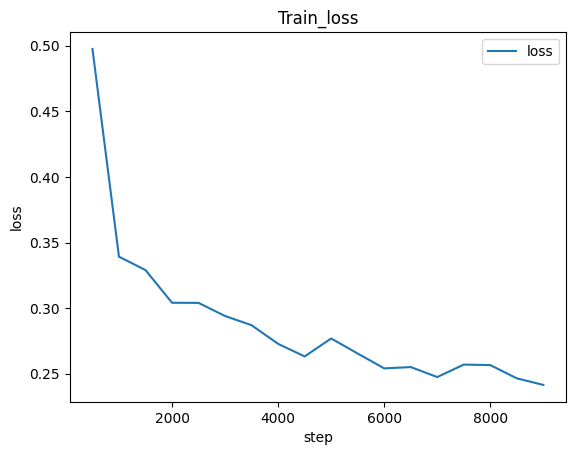

In [ ]:
import matplotlib.pyplot as plt
hist=pd.DataFrame(trainer.state.log_history)

plt.figure()
hist.dropna(subset=['loss']).plot(x='step', y='loss', kind='line')
plt.title('Train_loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [ ]:
test_reviews = [
    "완전 최고예요. 다시 보고 싶습니다!",
    "스토리가 탄탄하고 배우들의 연기도 훌륭했습니다.",
    "감동적인 장면이 많아서 눈물이 났어요.",
    "유쾌하고 즐거운 영화였습니다. 추천합니다!",
    "시간 가는 줄 모르고 봤어요. 정말 재밌네요.",


    "지루하고 끝까지 보기 힘들었어요.",
    "스토리가 엉망이고 개연성이 전혀 없네요.",
    "배우들 연기가 너무 어색했어요.",
    "별로였어요. 다시 보고 싶지 않습니다.",
    "시간 낭비였습니다. 돈 아까워요.",
]

In [ ]:
custom_ds = Dataset.from_dict({"document": test_reviews, "labels": [0]*len(test_reviews)})
custom_ds = custom_ds.map(lambda x: tok(x["document"], truncation=True, padding='max_length', max_length=128))
custom_ds = custom_ds.remove_columns(["document"])
pred = trainer.predict(custom_ds)
labels = np.argmax(pred.predictions, axis=1)
labels



Map:   0%|          | 0/10 [00:00<?, ? examples/s]

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
test_reviews = [
    #  긍정
    "와 진짜 재밌었어요. 끝까지 몰입해서 봤습니다.",
    "배우들 연기력 미쳤네요… 감탄했어요.",
    "마지막 장면에서 눈물 터졌습니다ㅠㅠ",
    "연출도 깔끔하고 스토리도 좋아서 추천해요!",
    "시간 순삭… 또 보고 싶어요.",

    #  부정
    "스토리가 너무 뻔하고 지루했어요.",
    "연기 어색해서 집중이 안 됐습니다.",
    "특수효과만 괜찮았지 전체적으로 별로였어요.",
    "보는 내내 시간 아깝다는 생각만 했습니다.",
    "처음부터 끝까지 답답했어요.",

    # 중립/혼합
    "배우들 연기는 좋았는데 내용은 좀 아쉬웠습니다.",
    "OST는 정말 좋았지만 스토리는 별로였어요.",
    "중반까지는 재밌었는데 결말이 너무 허무했네요.",
    "영상미는 훌륭했지만 캐릭터 매력은 부족했습니다.",
    "웃긴 장면은 있었지만 전체적으로 무난했어요."
]


In [ ]:
custom_ds = Dataset.from_dict({"document": test_reviews, "labels": [0]*len(test_reviews)})
custom_ds = custom_ds.map(lambda x: tok(x["document"], truncation=True, padding='max_length', max_length=128), batched=True)
custom_ds = custom_ds.remove_columns(["document"])
pred = trainer.predict(custom_ds)
labels = np.argmax(pred.predictions, axis=1)
labels

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

# **실험 2:**

**model:** 'klue/bert-base'

**추가:** data collator+ dynamic batching

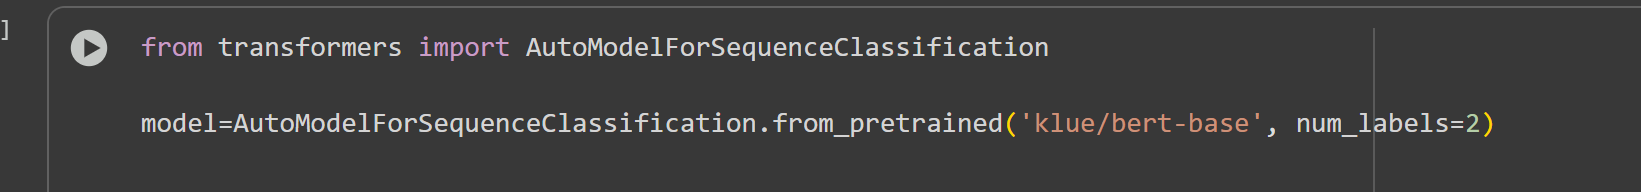

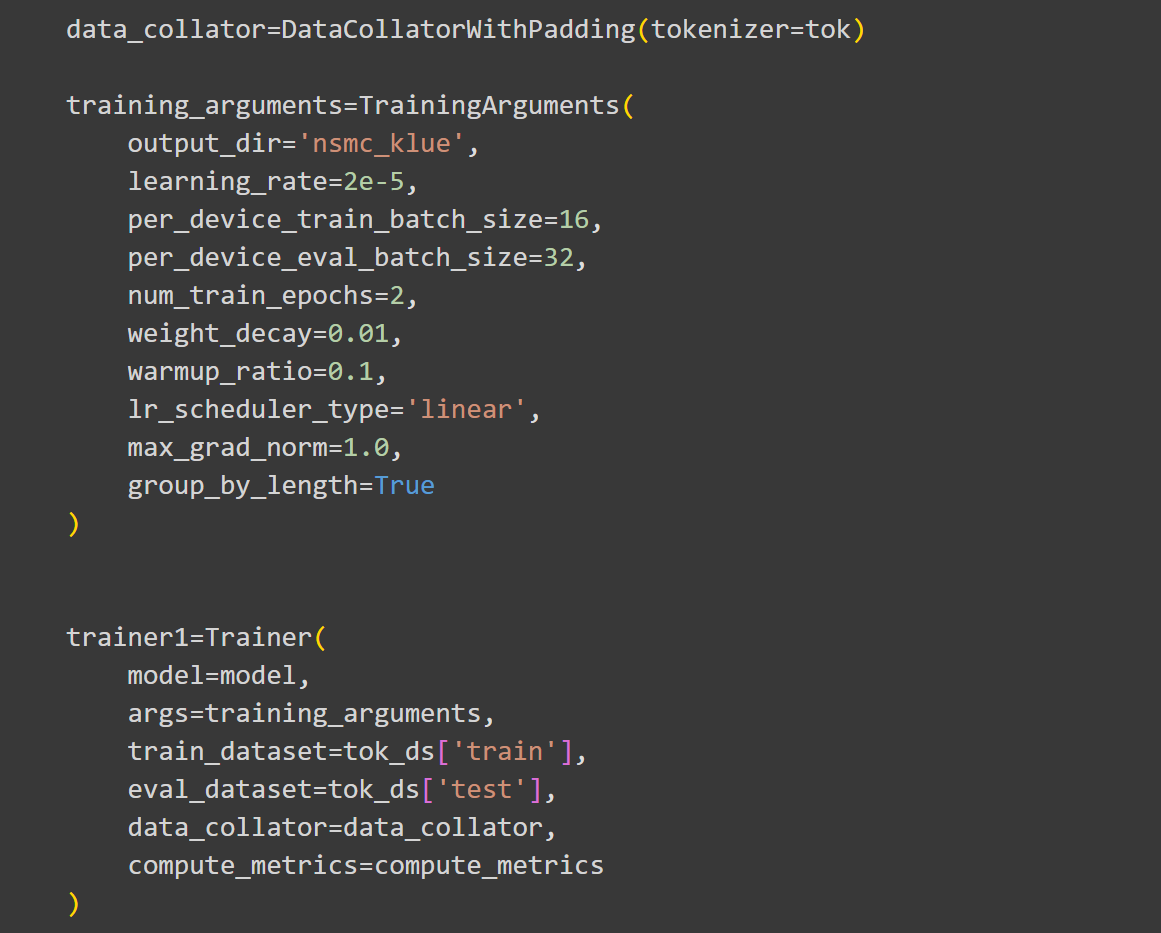

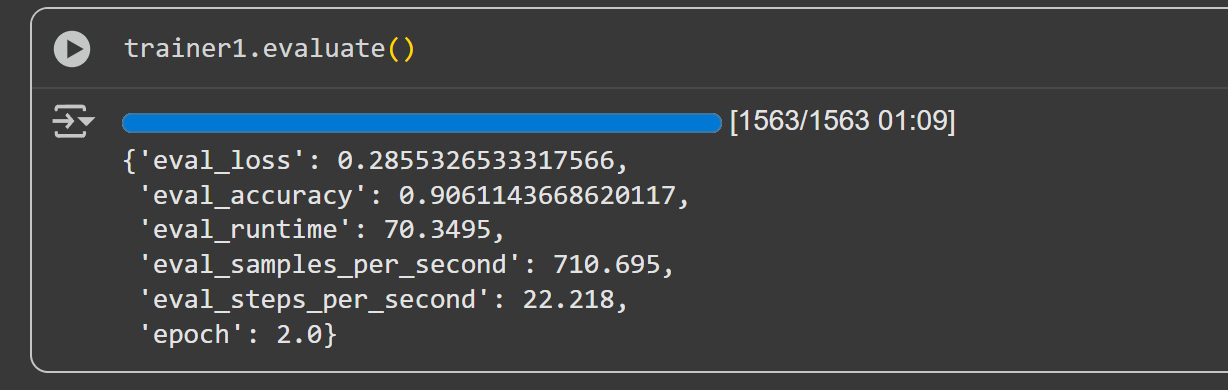

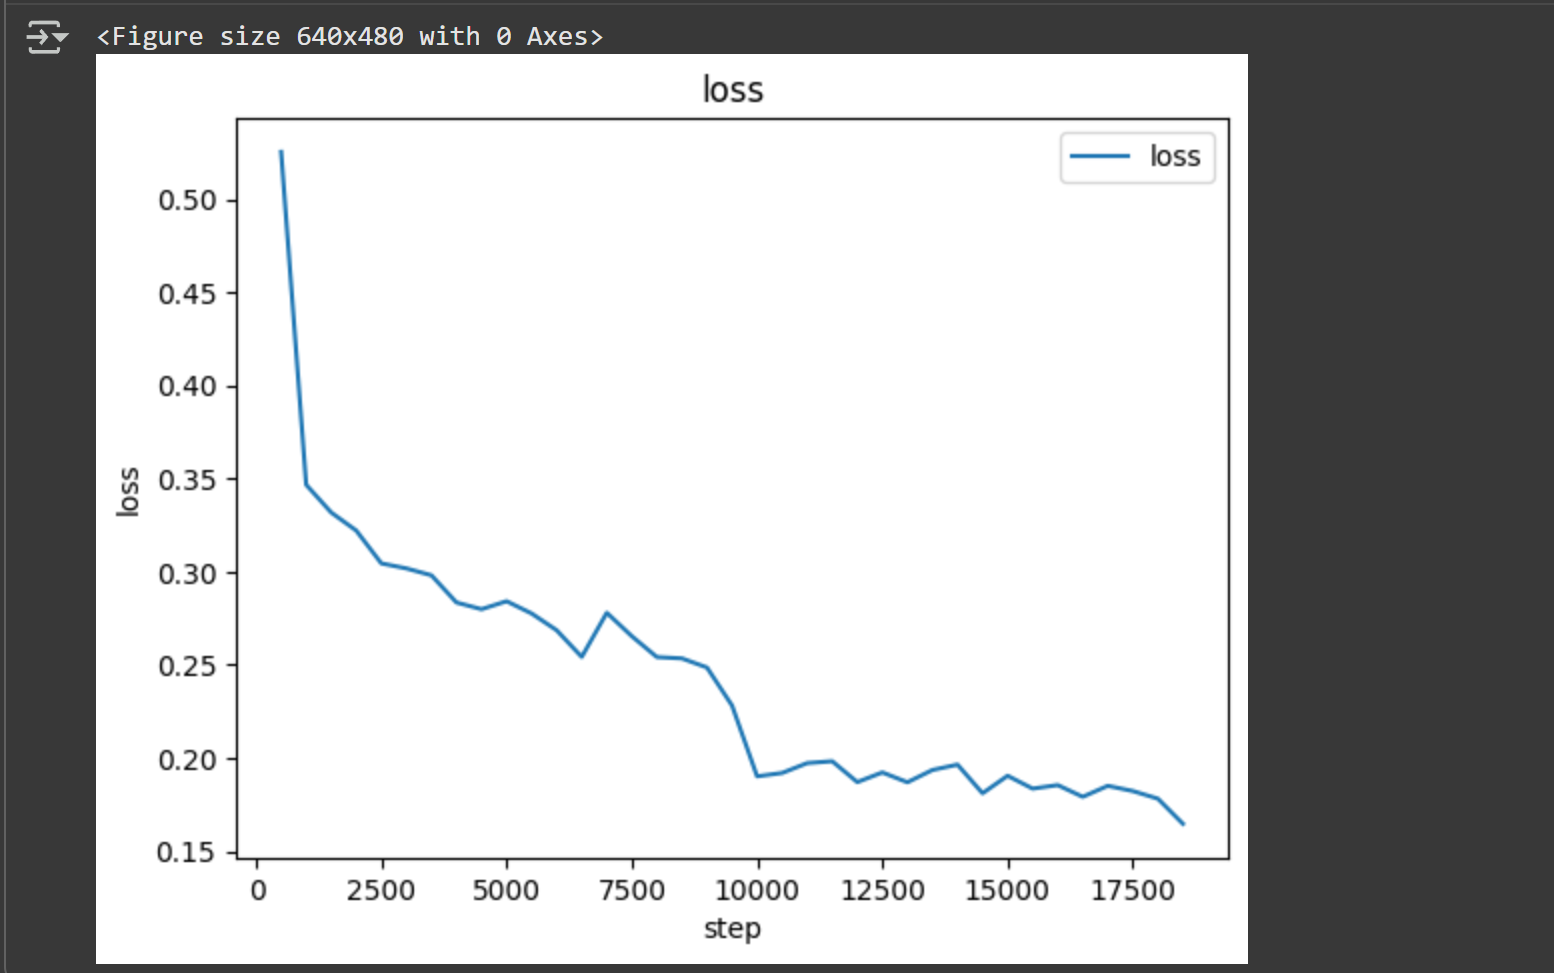

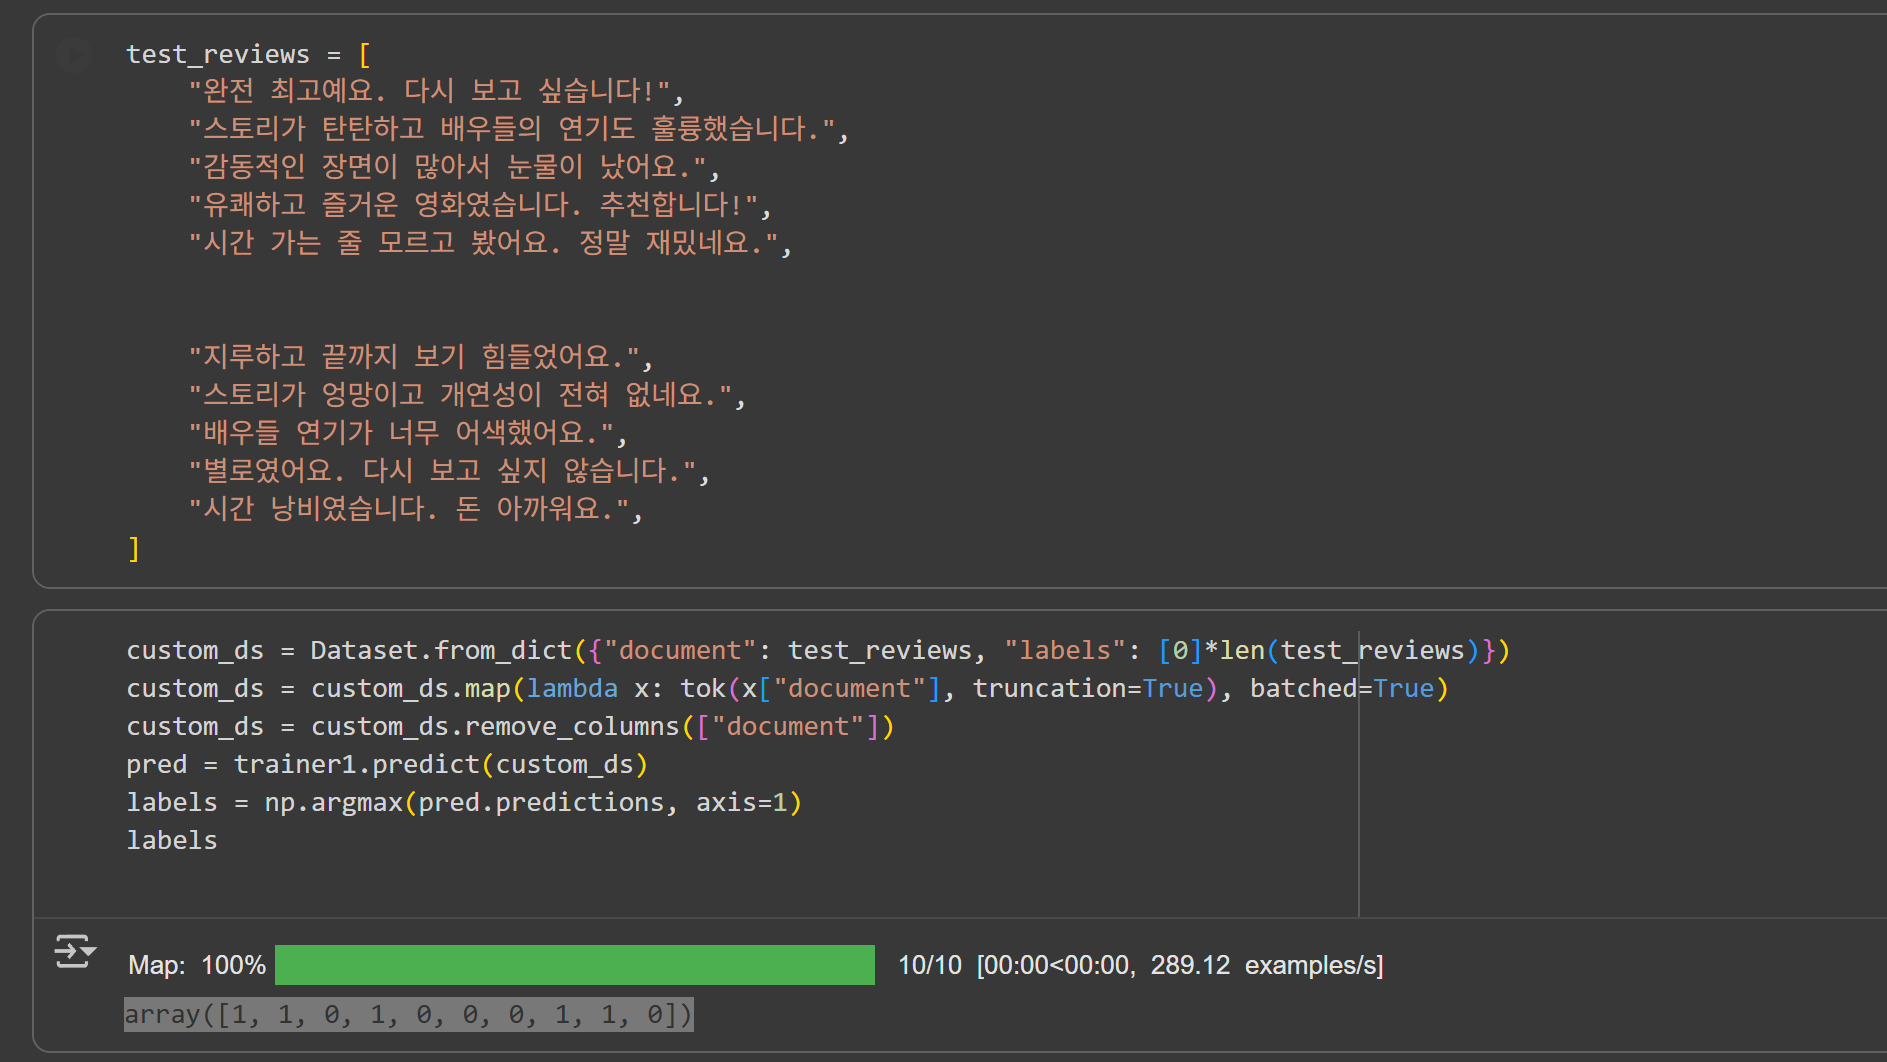

# **실험 3:**

**model:** klue/roberta-base

**추가 arg:**

    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    max_grad_norm=1.0,


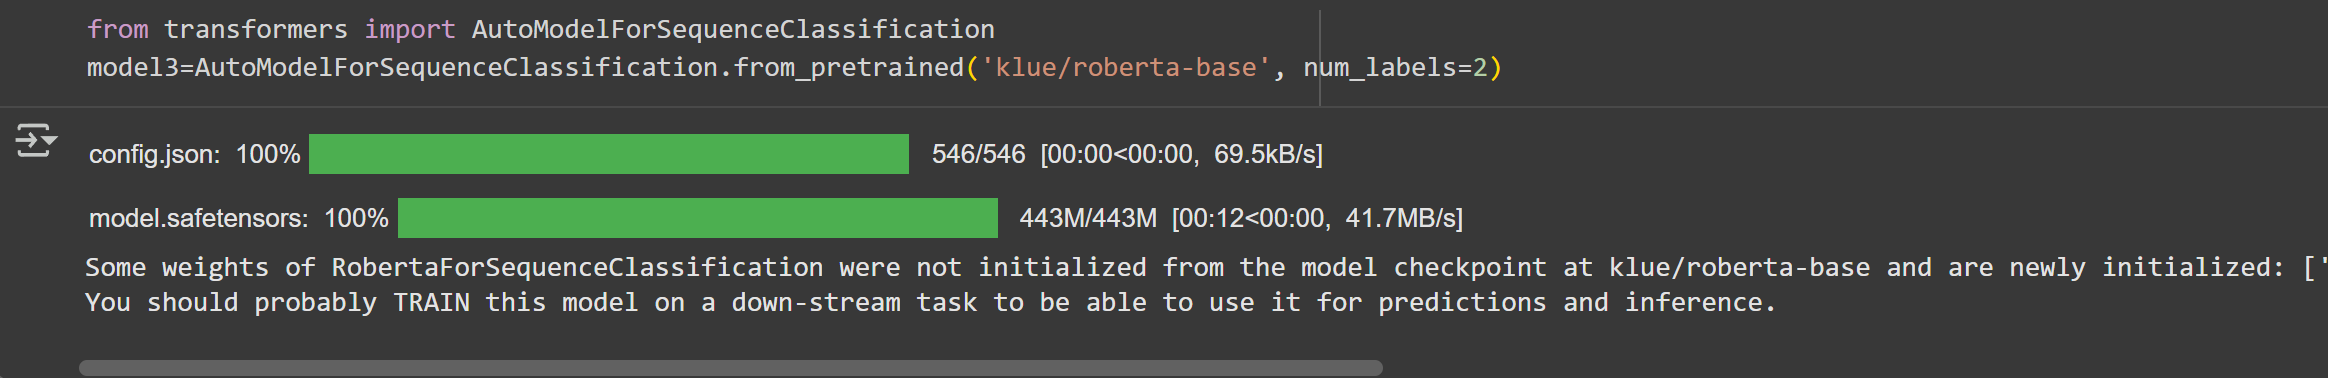

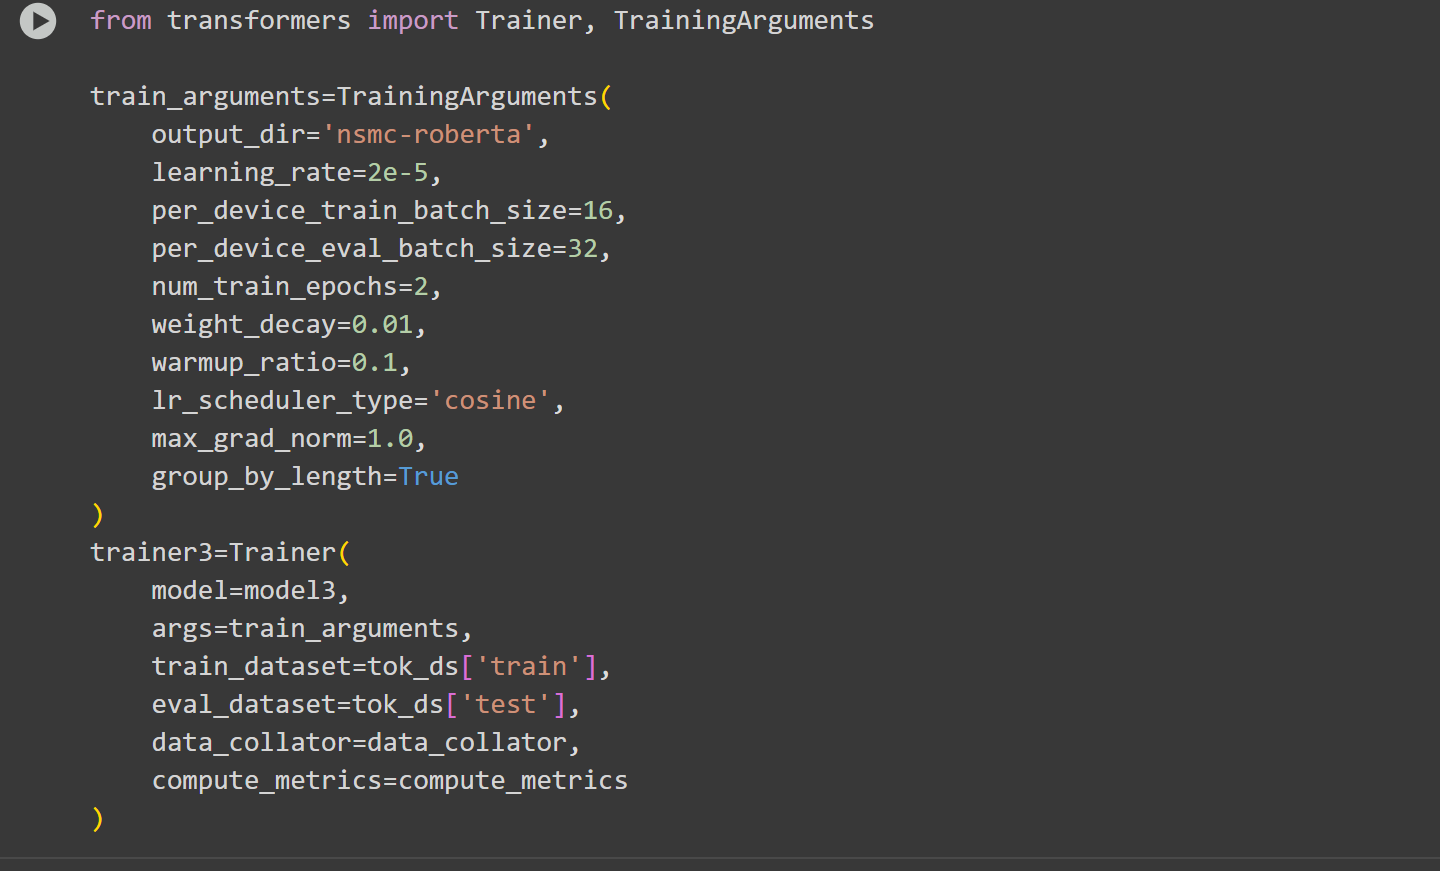

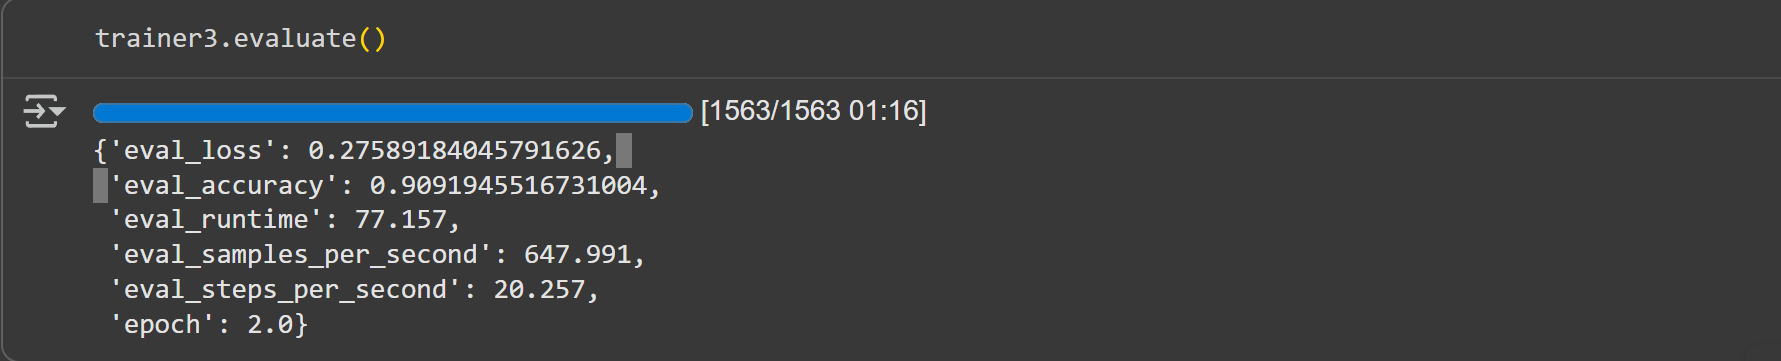

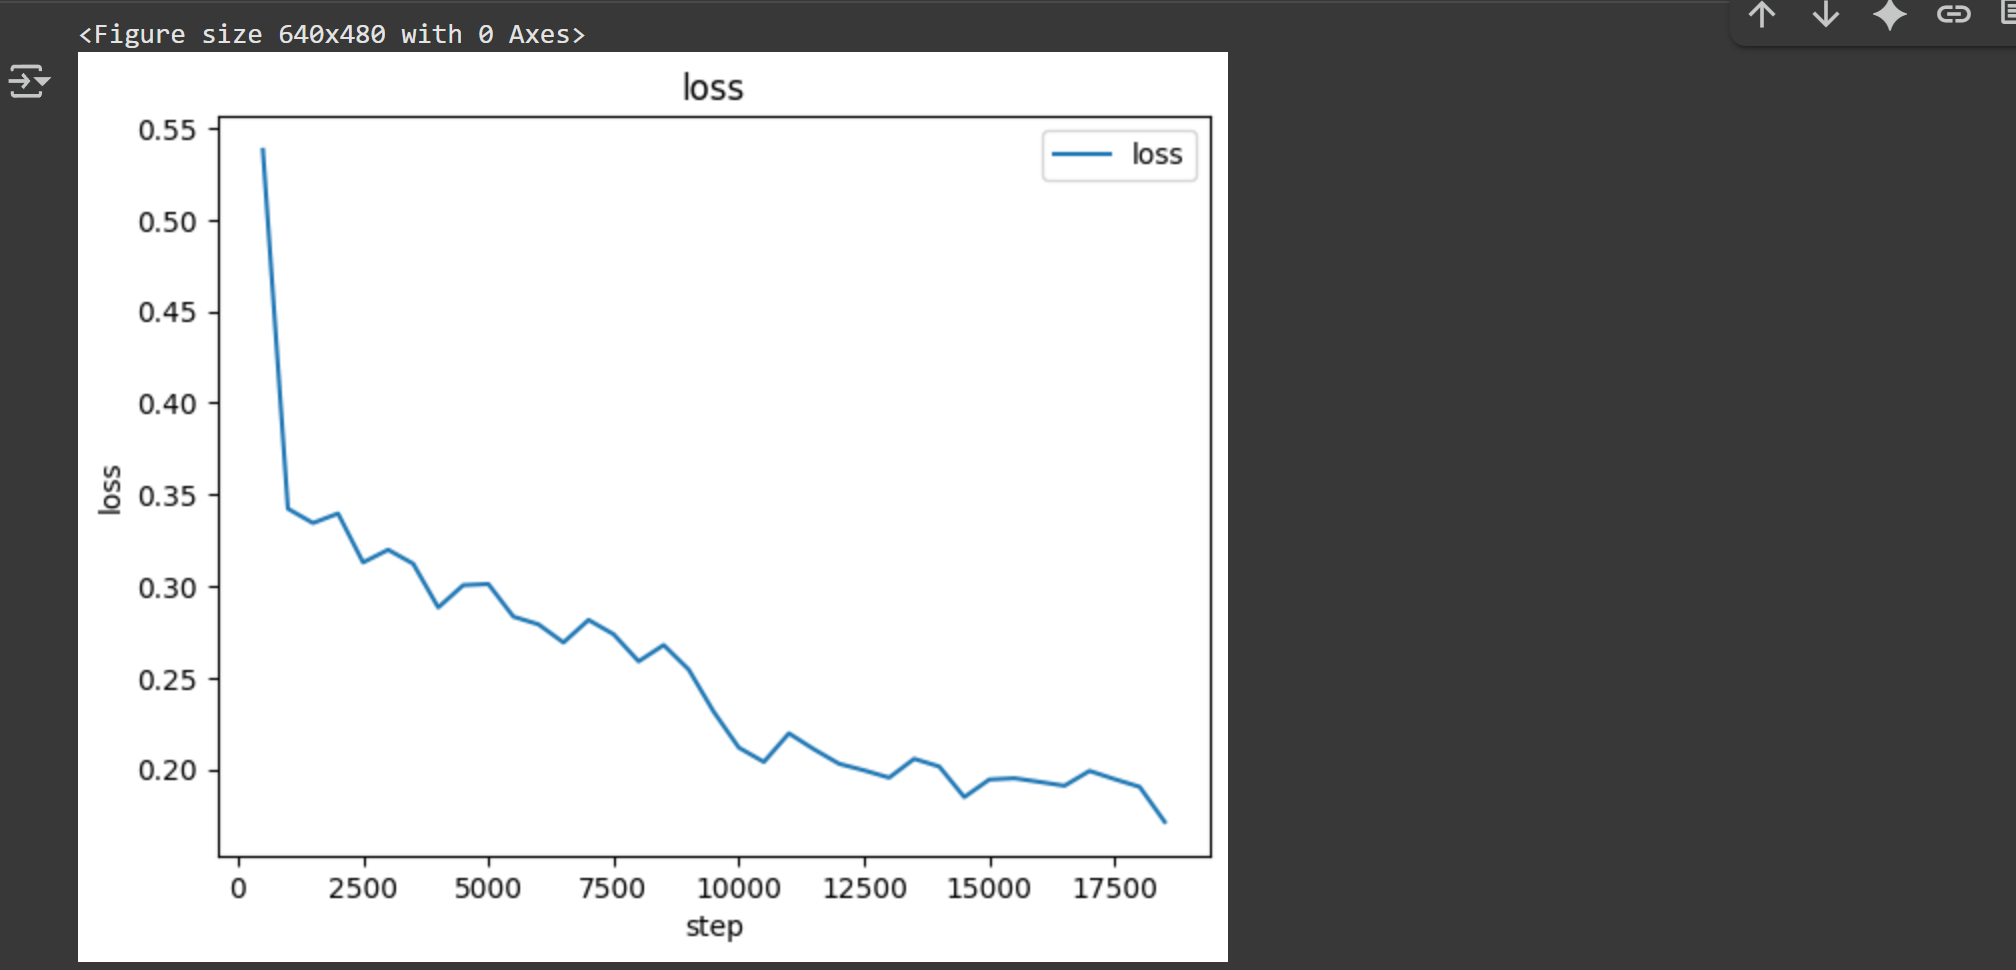

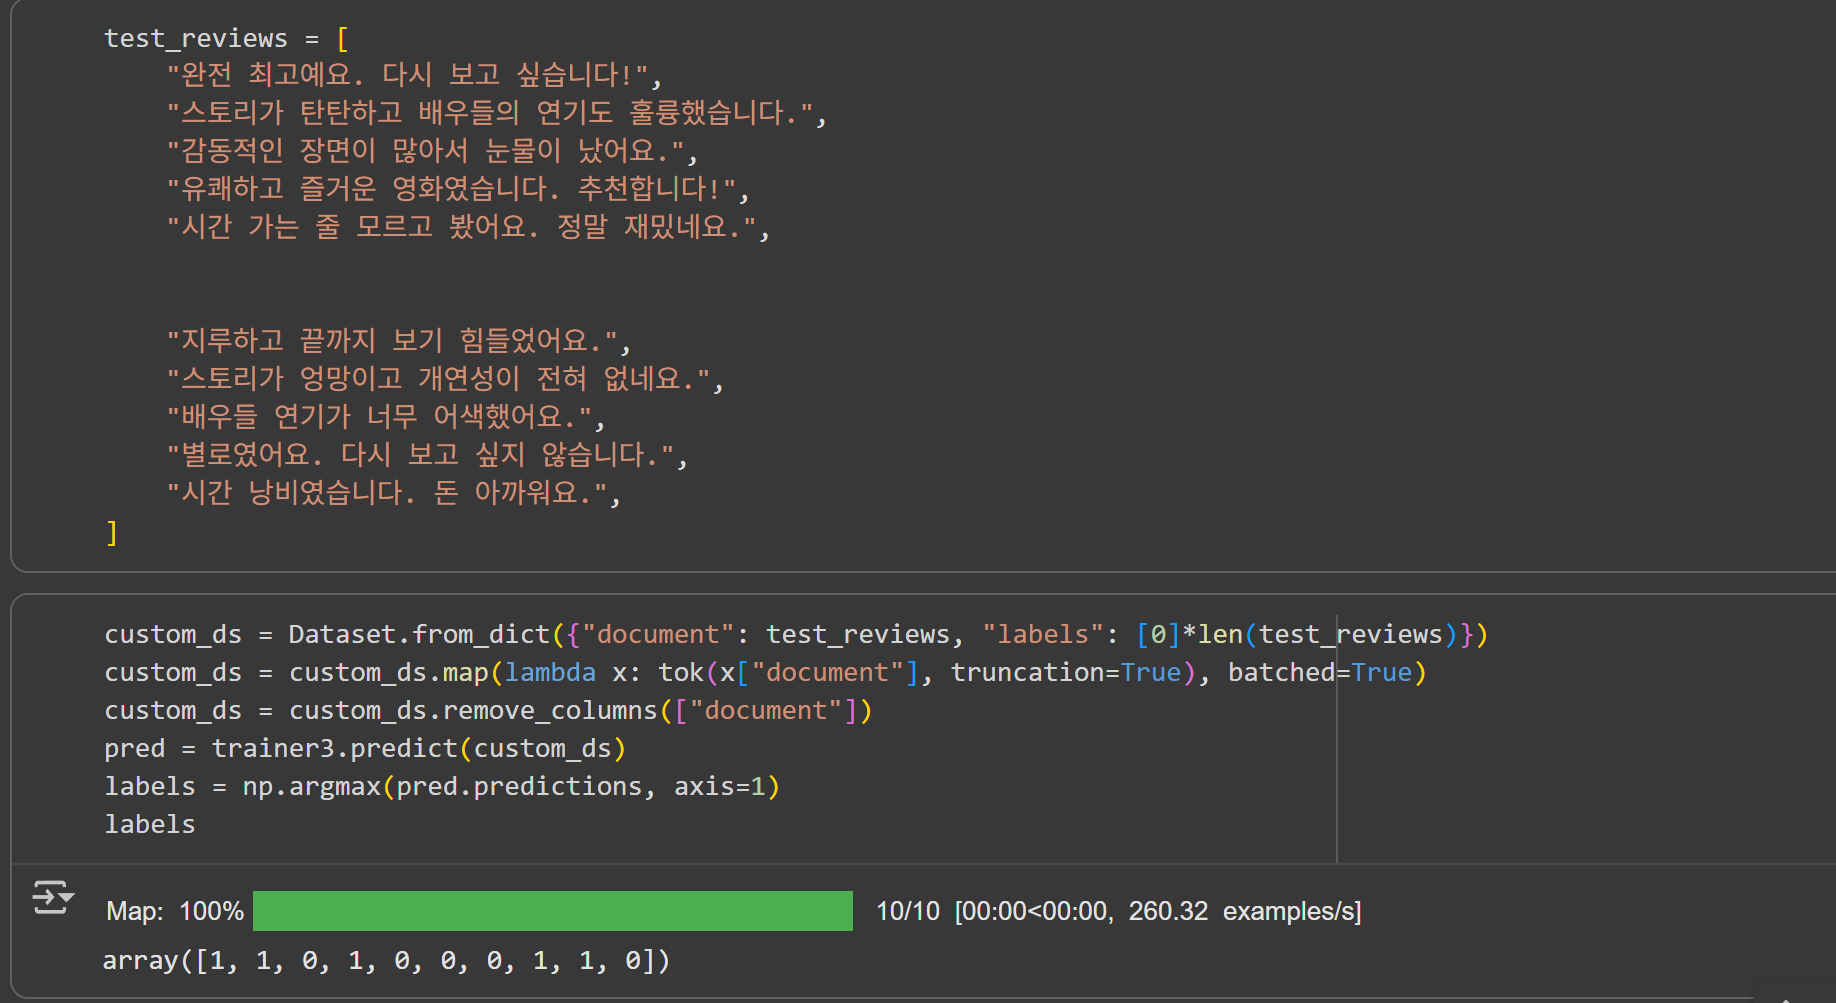

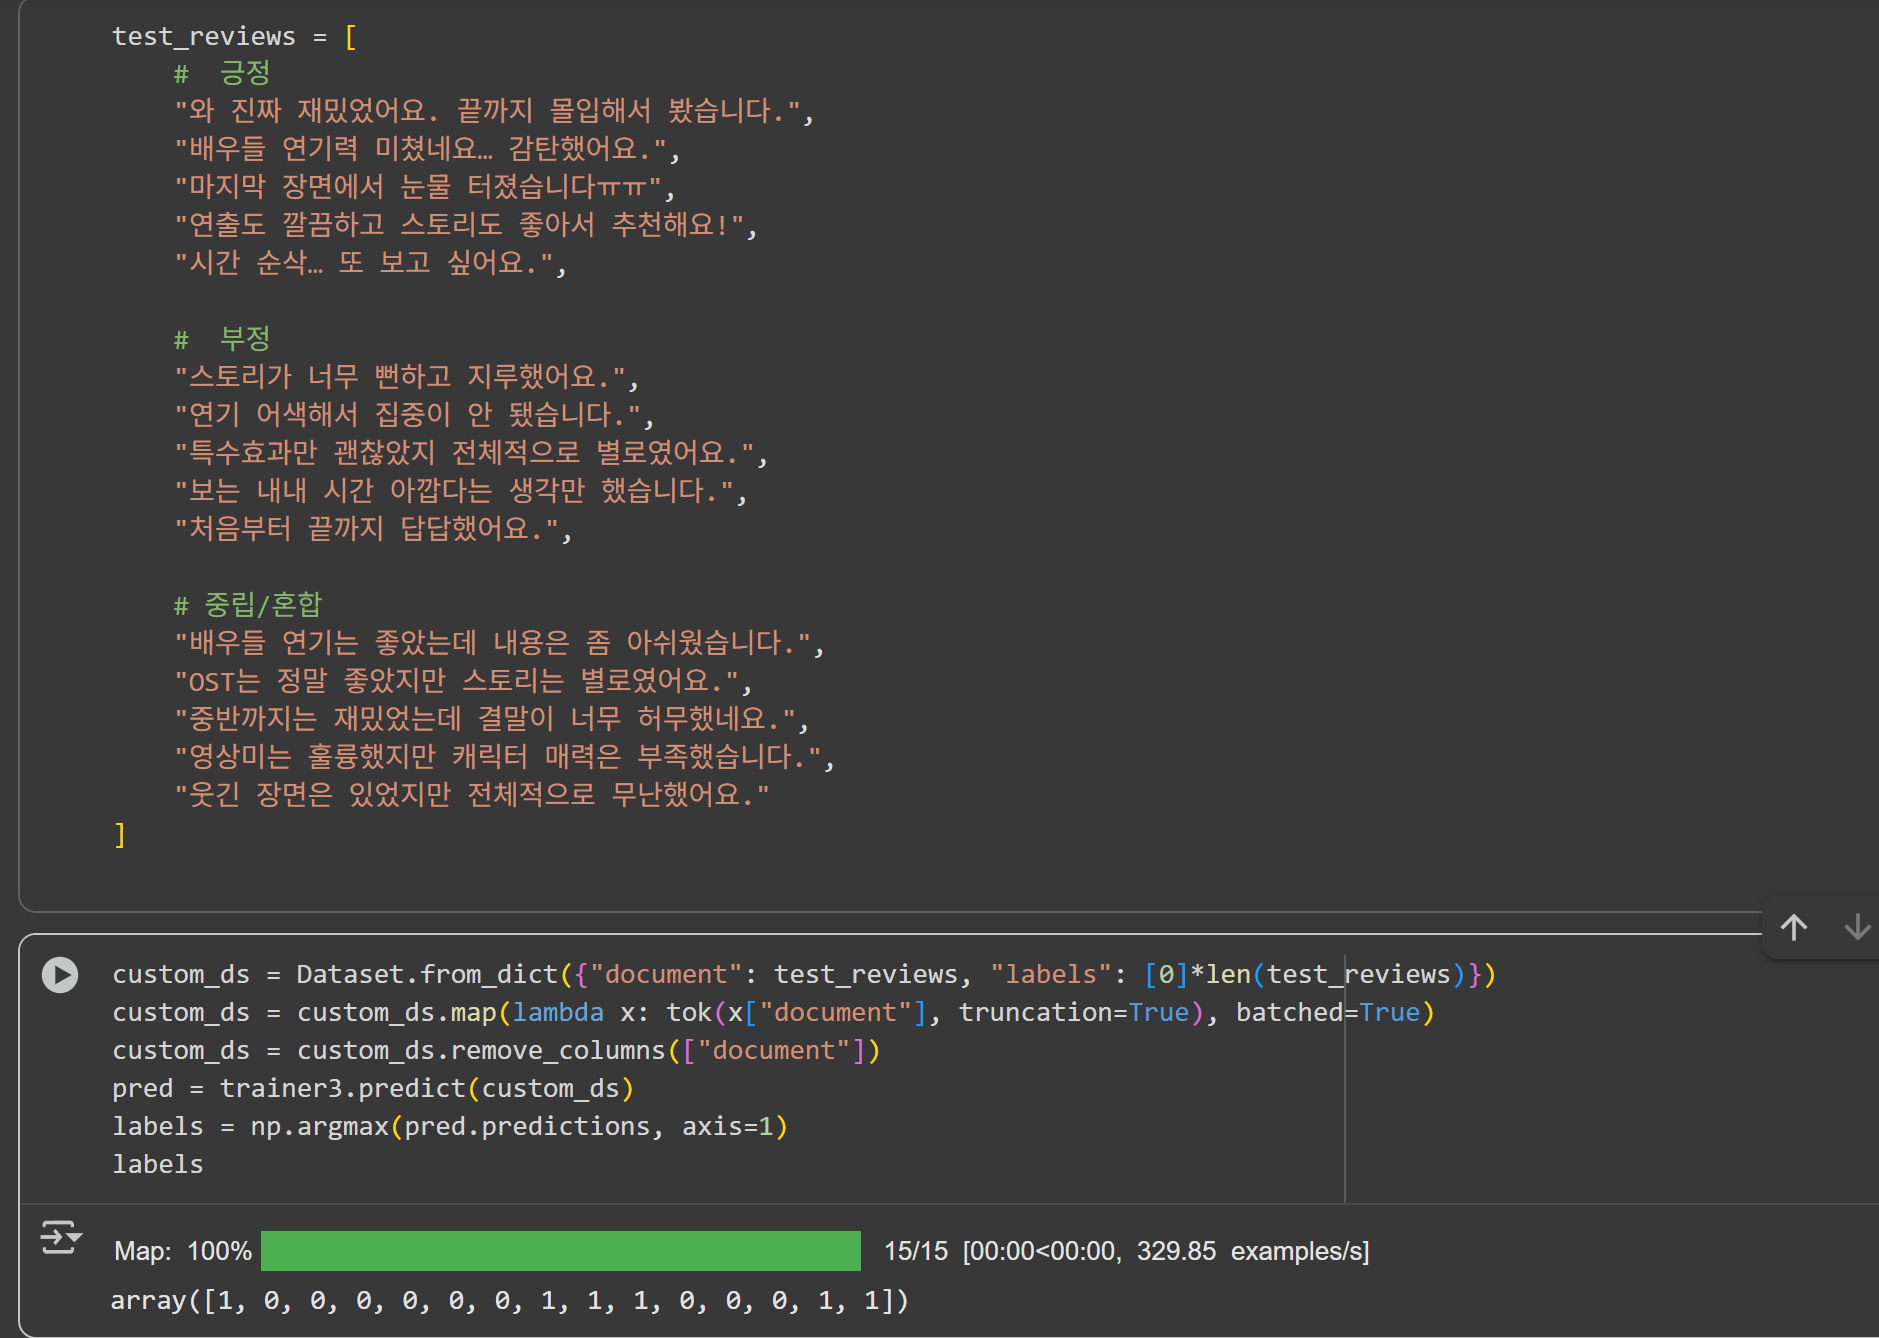

# **회고:**

**실험 1 — 기본 설정 (dynamic padding, DataCollator 미사용).**

eval_accuracy ≈ 0.903, eval_loss ≈ 0.248

사용자 정의 문장에서 비교적 안정적인 결과를 보였으며, 구어체나 감정적인 표현에 더 잘 대응하였다.

그러나 학습 속도는 느렸다.

**실험 2 — DataCollatorWithPadding 및 group_by_length (bucketing) 적용.**

eval_accuracy ≈ 0.906, eval_loss ≈ 0.286

학습 및 추론 속도가 약 4–5배 향상되었다.

하지만 사용자 정의 문장에서 성능이 약간 떨어졌으며, 공식 테스트셋에서는 더 좋아졌지만 슬랭이나 감정적인 표현을 자주 혼동하였다.

**실험 3 — klue/roberta-base 모델과 cosine scheduler 사용.**

eval_accuracy ≈ 0.909, eval_loss ≈ 0.276

공식 테스트셋에서는 가장 좋은 결과를 보였다.

그러나 사용자 정의 문장에서는 여전히 오류가 있었으며, 표준 리뷰는 잘 분류하지만 짧은 부정 표현(“별로였어요”, “돈 아까워요”)이나 감정적인 긍정 표현(“눈물 났어요”, “시간 순삭”)을 혼동하였다.

**주요 관찰 사항**

공식 테스트셋에서의 정확도 향상이 항상 사용자 정의 문장에서의 성능 개선으로 이어지지는 않는다. 이는 두 데이터가 스타일과 내용에서 차이가 있기 때문이다.

dynamic padding과 bucketing의 사용은 속도 향상에는 크게 기여하지만, 보다 “실제적인” 문장들에 대한 일반화 성능 개선을 보장하지는 않는다.

RoBERTa 모델이 테스트셋에서 가장 좋은 지표를 보였으나, 실제 사용자 데이터에서는 추가적인 개선이 필요하다.

**왜 Collator와 dynamic padding을 추가했을 때 직접 작성한 문장들에서는 성능(예측 품질)이 더 나빠졌다?**

maybe:

첫 번째 실험에서는 max_length가 고정되어 있었기 때문에 각 배치에 <pad> 토큰이 많이 포함되어 있었습니다.

이것은 인위적으로 학습을 더 어렵게 만들어 모델이 NSMC 데이터에만 과도하게 맞춰지지 않도록 했습니다.

결과적으로 모델은 암묵적인 **정규화 효과(regularization effect)**를 얻어 새로운 “노이즈가 많은” 문장들에도 더 잘 일반화할 수 있었습니다.

그러나 dynamic padding을 사용하면서 이러한 “정규화 효과”가 사라졌고, 학습은 원 데이터셋(NSMC)에는 더 효율적으로 되었지만, 분포가 다른(out-of-distribution) 사용자 문장들에는 덜 견고해졌습니다.